In [1]:
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import boto3
import sys
import os
sys.path.append(os.path.expanduser('../../')) # annoying workaround, beware hardcoding!!!
from scripts.utils.file_helpers import to_zarr

In [2]:
## set-up for AWS
'''
Note:
This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
'''
s3_client = boto3.client('s3')
bucket_name = 'ca-climate-index'
directory = '2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa'

In [3]:
# open soil moisture anomoly data through xarray
soil_moisture_anom = xr.open_dataset('sfc_soil_moisture_anomaly_2015-2022.nc')
soil_moisture_anom

<xarray.Dataset>
Dimensions:    (time: 889, latitude: 106, longitude: 78)
Coordinates:
  * time       (time) datetime64[ns] 2015-04-03T12:00:00 ... 2022-08-03T12:00:00
  * latitude   (latitude) float64 32.2 32.3 32.39 32.48 ... 41.86 41.95 42.05
  * longitude  (longitude) float64 -124.8 -124.7 -124.5 ... -114.3 -114.1 -114.0
Data variables:
    ssma       (time, latitude, longitude) float32 ...

In [4]:
# establish working range for parameters outlined in the xarray
lat_min = soil_moisture_anom['latitude'].min()
lat_max = soil_moisture_anom['latitude'].max()
lon_min = soil_moisture_anom['longitude'].min()
lon_max = soil_moisture_anom['longitude'].max()

soil_moisture_analysis = soil_moisture_anom['ssma'].sel(  
                      latitude=slice(lat_min, lat_max),  
                      longitude=slice(lon_min, lon_max),  
                      )

lat_range = lat_max - lat_min
lon_range = lon_max - lon_min


In [5]:
soil_moisture_analysis

<xarray.DataArray 'ssma' (time: 889, latitude: 106, longitude: 78)>
[7350252 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2015-04-03T12:00:00 ... 2022-08-03T12:00:00
  * latitude   (latitude) float64 32.2 32.3 32.39 32.48 ... 41.86 41.95 42.05
  * longitude  (longitude) float64 -124.8 -124.7 -124.5 ... -114.3 -114.1 -114.0
Attributes:
    long_name:           surface_soil_moisture_anomaly
    units:               unitless
    composite_interval:  3 day
    comment:             3 day mean composite estimate
    cell_methods:        time: mean

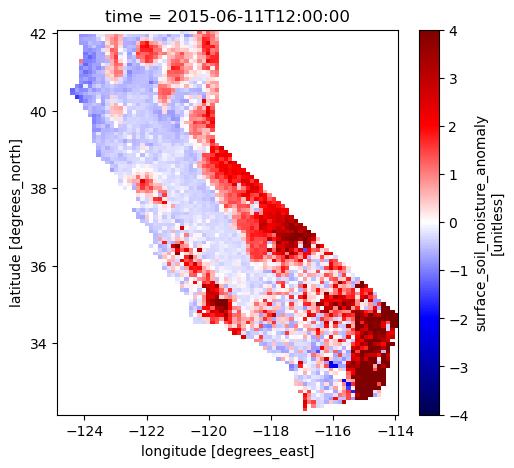

In [6]:
# visualize the soil moisture for the first date within the data
soil_moisture_analysis.isel(time=23).plot.imshow(vmin=-4., vmax=4., cmap='seismic', aspect=lon_range/lat_range, size=5)

In [7]:
# load the census tracts spatial data for California
ca_boundaries = gpd.read_file('ca_tract_tiger')

# check the current coordinate system of the census tracts data
print("Original CRS of Census Tracts Data:")
print(ca_boundaries.crs)

Original CRS of Census Tracts Data:
EPSG:4269


In [8]:
# reproject soil moisture data to the same coordinate system as census tract
temp_soil_reproj = soil_moisture_analysis.rio.set_crs('EPSG:4269')

In [9]:
# ensure data shape is carried over after reproject
temp_soil_reproj.values.shape

(889, 106, 78)

In [10]:
# clip the reporjected soil moisture data to California specific census parameter
temp_soil_reproj.rio.clip(geometries=ca_boundaries.geometry)

<xarray.DataArray 'ssma' (time: 889, latitude: 101, longitude: 73)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.23364224,
                 nan,         nan],
        ...,
        [        nan,         nan, -0.9499847 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -1.5658404 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -1.3223482 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.2933374 ,
                 nan,         nan],
...
        [        nan,         nan, -0.47742638, ...,         nan,
                 nan,         nan],
        [        nan,         nan, -0.16416243, ...,         nan,
                 nan,         nan],
        [        nan,         nan, -0.36185068, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.30239356,
                 nan,         nan],
        ...,
        [        nan,         nan, -0.44603717, ...,         nan,
                 nan,         nan],
        [        nan,         nan, -0.5337103 , ...,         nan,
                 nan,         nan],
        [        nan,         nan, -0.20605819, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2015-04-03T12:00:00 ... 2022-08-03T12:...
  * latitude     (latitude) float64 32.58 32.67 32.77 ... 41.77 41.86 41.95
  * longitude    (longitude) float64 -124.4 -124.2 -124.1 ... -114.4 -114.3
    spatial_ref  int64 0
Attributes:
    long_name:           surface_soil_moisture_anomaly
    units:               unitless
    composite_interval:  3 day
    comment:             3 day mean composite estimate
    cell_methods:        time: mean

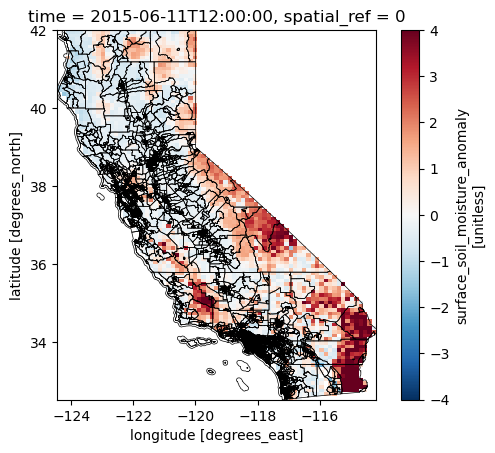

In [11]:
visualize_ca_soil = temp_soil_reproj.rio.clip(geometries=ca_boundaries.geometry).isel(time=23)
fig, ax = plt.subplots()
visualize_ca_soil.plot(ax=ax)

# Plot the shapefile on top of the xarray plot
ca_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# Show the plot
plt.show()

In [12]:
# s3 bucket path information
top_dir = '2b_reproject'
domain = 'natural_systems'
indicator = 'agricultural_productivity_conservation'
data_source = 'usda_nasa'
save_name = 'soil_moisture_ca_reproject'
# now zarrify and upload
to_zarr(temp_soil_reproj, top_dir, domain, indicator, data_source, save_name)

In [13]:
# load in the uploaded zarr to check on everything
aws_path = "s3://ca-climate-index/{0}/{1}/{2}/{3}/".format(
    top_dir, domain, indicator, data_source)
filepath_zarr = aws_path+save_name+".zarr"

# Open and plot one of the files to confirm it all worked 
ds = xr.open_dataset(
    filepath_zarr, 
    engine="zarr",
    consolidated=False,
)
ds

<xarray.Dataset>
Dimensions:    (latitude: 106, longitude: 78, time: 889)
Coordinates:
  * latitude   (latitude) float64 32.2 32.3 32.39 32.48 ... 41.86 41.95 42.05
  * longitude  (longitude) float64 -124.8 -124.7 -124.5 ... -114.3 -114.1 -114.0
  * time       (time) datetime64[ns] 2015-04-03T12:00:00 ... 2022-08-03T12:00:00
Data variables:
    ssma       (time, latitude, longitude) float32 ...

Legacy code to save netcdf and upload to s3

In [ ]:
# save newly projected data as a netcdf file
temp_soil_reproj.to_netcdf('soil_moisture_ca_reproject.nc')

In [ ]:
# upload to aws bucket
with open('soil_moisture_ca_reproject.nc', 'rb') as data:
        s3_client.upload_fileobj(data, bucket_name, f"{directory}/{'soil_moisture_ca_reproject.nc'}")
        print(f"Merged and sorted files written to: soil_moisture_ca_reproject.nc")